In [1]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam

In [2]:
cols=['dered_u','dered_g','dered_r','dered_i','dered_z','dered_color_ug','dered_color_gr','dered_color_ri','dered_color_iz','dered_frac_uz','C']
data = pd.read_csv('./Data/SDSS_DR12_awe2_0.csv', usecols=['z']+cols)
X = data[cols]
Y = data[['z']]
X_cut_1 = X[ Y['z']<=0.4]
Y_cut_1 = Y[ Y['z']<=0.4]

del data,X,Y

In [3]:
NB_BINS = 60 * 3
ZMIN = 0.0
ZMAX = 0.4
BIN_SIZE = (ZMAX - ZMIN) / NB_BINS
range_z = np.linspace(ZMIN, ZMAX, NB_BINS + 1)[:NB_BINS]

In [4]:
x_train = X_cut_1.iloc[0:175000].values #175,000 train
y_train = tf.keras.utils.to_categorical(np.round((180-1)*(Y_cut_1.iloc[0:175000].values[:,0]/0.4),0).astype(int))

x_val = X_cut_1.iloc[175000:300000].values #125,000 val
y_val_examine = (Y_cut_1.iloc[175000:300000].values[:,0])
y_val = tf.keras.utils.to_categorical(np.round((180-1)*(Y_cut_1.iloc[175000:300000].values[:,0]/0.4),0).astype(int))

x_test = X_cut_1.iloc[300000::].values #~200,000 test
y_test = tf.keras.utils.to_categorical(np.round((180-1)*(Y_cut_1.iloc[300000::].values[:,0]/0.4),0).astype(int))

In [5]:
def MLP(Hlayer,Hneuron,Drate):
    model = Sequential(name=f'{Hlayer}_hidden_layer')
    model.add(Dense(Hneuron, activation='relu', input_dim=In,name=f'hidden_layer_1'))
    model.add(Dropout(Drate,name=f'dropout1_{Drate}'))
    for i in range(Hlayer-1):
        model.add(Dense(Hneuron, activation='relu',name=f'hidden_layer_{i+2}'))
        model.add(Dropout(Drate,name=f'dropout{i+2}_{Drate}'))
        
    model.add(Dense(180, activation='softmax',name=f'output_layer'))
    return model

from matplotlib.ticker import MaxNLocator
def lossplot(history):
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    itera = np.arange(1,epochs+1,1).astype(int)
    plt.plot(itera,train_loss,'orange',label='train')
    plt.plot(itera,val_loss,'blue',label='val')
    plt.xlabel('epoch')
    plt.ylabel('LOSS')
    plt.legend()
    ax=plt.gca()
    ax.set_xlim([0,epochs])
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    plt.show()

titles=['train','val','test']
def histplot(X,Y):
    fig,axes = plt.subplots(1,3,figsize=(12,4))
    for i in range(len(X)):
        x = X[i]
        y = Y[i]
        ax = axes[i]
        y_pred = model.predict(x[::5])
        ax.hist(np.sum(y[::5]*range_z,1),bins=range_z,density=True,label='true dist',alpha=0.7)
        ax.hist(np.sum(y_pred*range_z,1),bins=range_z,density=True,label='predicted',alpha=0.7)
        ax.set_title(titles[i])
        ax.set_xlim([0.0,0.4])
        ax.set_ylim([0.0,12.0])
        ax.legend()
    
    fig.tight_layout()
    plt.show()

In [6]:
In = len(cols)
Hlayer = 3
Hneuron = 30
Drate = 0.1
l_rate = 1e-3
batch_size = 300
epochs = 30

filepath='MLP_PDF_MODEL.hdf5'
ModelCheckpointCB = ModelCheckpoint(filepath, monitor='val_loss', verbose=1,
                    save_best_only=True, save_weights_only=False, mode='auto')

model = MLP(Hlayer,Hneuron,Drate)
model.summary()

adam = Adam(lr=l_rate)
model.compile(optimizer=adam, loss='categorical_crossentropy')
history = model.fit(x=x_train,y=y_train,batch_size=batch_size,epochs=epochs,verbose=1, 
                    validation_data=(x_val,y_val),callbacks=[ModelCheckpointCB])

Model: "3_hidden_layer"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
hidden_layer_1 (Dense)       (None, 30)                360       
_________________________________________________________________
dropout1_0.1 (Dropout)       (None, 30)                0         
_________________________________________________________________
hidden_layer_2 (Dense)       (None, 30)                930       
_________________________________________________________________
dropout2_0.1 (Dropout)       (None, 30)                0         
_________________________________________________________________
hidden_layer_3 (Dense)       (None, 30)                930       
_________________________________________________________________
dropout3_0.1 (Dropout)       (None, 30)                0         
_________________________________________________________________
output_layer (Dense)         (None, 180)            

Epoch 27/30
174900/175000 [============================>.] - ETA: 0s - loss: 3.6669
Epoch 00027: val_loss improved from 3.60402 to 3.60202, saving model to MLP_PDF_MODEL.hdf5
175000/175000 [==============================] - 17s 96us/sample - loss: 3.6668 - val_loss: 3.6020
Epoch 28/30
174900/175000 [============================>.] - ETA: 0s - loss: 3.6595
Epoch 00028: val_loss improved from 3.60202 to 3.59616, saving model to MLP_PDF_MODEL.hdf5
175000/175000 [==============================] - 16s 89us/sample - loss: 3.6595 - val_loss: 3.5962
Epoch 29/30
174600/175000 [============================>.] - ETA: 0s - loss: 3.6554
Epoch 00029: val_loss improved from 3.59616 to 3.58502, saving model to MLP_PDF_MODEL.hdf5
175000/175000 [==============================] - 15s 87us/sample - loss: 3.6554 - val_loss: 3.5850
Epoch 30/30
174900/175000 [============================>.] - ETA: 0s - loss: 3.6569
Epoch 00030: val_loss did not improve from 3.58502
175000/175000 [============================

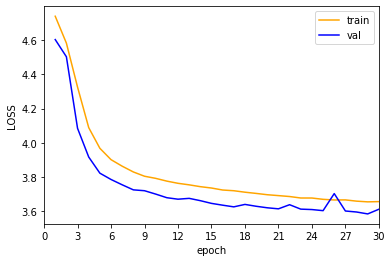

In [7]:
lossplot(history)

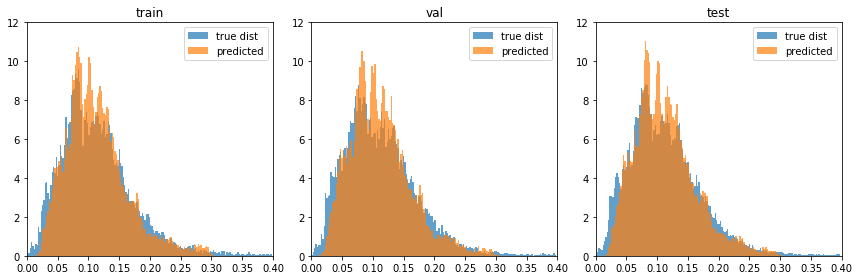

In [8]:
model.load_weights(filepath)
histplot([x_train,x_val,x_test],[y_train,y_val,y_test])

(125000,)
CRPS:  0.0935
MAD:  0.0158
bias:  -0.0014
outlier_fraction_eta pasquet:  0.0024
RMS:  0.0207
outlier fraction LSST:  0.0143


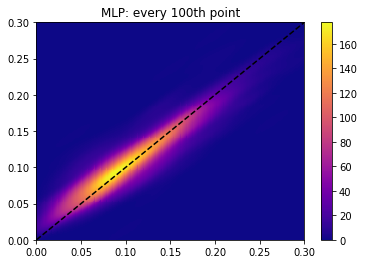

(125000,)
(125000,)
(125000, 180)


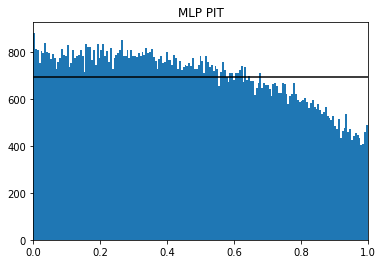

0.000544
 
Normal distribution's fraction is 0.0002


In [9]:
y_pred = model.predict(x_val)

#the analysis code
from scipy.stats import kde
x=y_val_examine
y=np.sum(range_z*y_pred,1) #for categorical
#y=y_pred[:,0] #for regression


#CRPS, FOR CLASS ONLY:
z_bins = np.argmax(y_val,axis=1)
CRPS=np.zeros(len(y_val))
for i in range(len(CRPS)):
    CRPS[i] = (np.sum((np.cumsum(y_pred[i,0:z_bins[i]]))**2) + np.sum((np.cumsum(y_pred[i,z_bins[i]::])-1)**2)) * BIN_SIZE
print(np.shape(CRPS))
CRPS_estimator=np.mean(CRPS)

#summary stats
residuals = (x-y)/(1+x)
bias = np.mean(residuals)
MAD = 1.4826*np.median(abs(residuals - np.median(residuals)))
outlier_fraction_eta = len(residuals[residuals > 5*MAD])/len(residuals)
eta_LSST = len(residuals[residuals > 3*MAD*(1+residuals)])/len(residuals)
RMS = np.sqrt(np.mean(np.square(residuals)))
print('CRPS: ',round(CRPS_estimator,4))
print('MAD: ',round(MAD,4))
print('bias: ',round(bias,4))
print('outlier_fraction_eta pasquet: ',round(outlier_fraction_eta,4))
print('RMS: ',round(RMS,4))
print('outlier fraction LSST: ',round(eta_LSST,4))
#KDE plot
nbins=300
x=x[::100]
y=y[::100]

k = kde.gaussian_kde([x,y])
xi, yi = np.mgrid[0:0.4:nbins*1j, 0:0.4:nbins*1j]
zi = k(np.vstack([xi.flatten(), yi.flatten()]))
 
# Make the plot
plt.pcolormesh(xi, yi, zi.reshape(xi.shape), cmap='plasma')
plt.plot([0,1],[0,1],'k--')
plt.xlim(0,0.3)
plt.ylim(0,0.3)
plt.title('MLP: every 100th point')
plt.colorbar()
plt.show()

def PIT(X,Out,title='title',string='plot.png',save=False,n_classes=180):
    """
    X = spectro Z array
    Out = probabilities array
    """
    print(np.shape(X))
    X_true_bin = np.round((X/0.4)*(n_classes-1),0).astype(int)
    X_true_bin[X_true_bin>=n_classes] = n_classes-1 
    PIT = []

    print(np.shape(X_true_bin))
    print(np.shape(Out))
    for i in range(len(X_true_bin)):
        PIT.append(np.sum((Out[i,:])[0:X_true_bin[i]]))

    PIT=np.asarray(PIT)

    n_bins=n_classes
    bins=np.linspace(0,1,n_bins)
    #draw the line that is if it was a perfect distribution. it would have..
    #len(PIT)/180 #number in each bin
    plt.hlines((len(PIT)/n_bins),0,1,colors='k',linestyles='solid')
    plt.xlim(0,1)
    plt.hist(PIT,bins)
    plt.title(title)
    if save==True:
        plt.savefig(string)
    plt.show()

    #catastropic outliers are thos with PIT values <0.0001 or >0.9999; a normal distribution would have 0.0002 fraction
    catastropic_outlier_fraction = (len(PIT[PIT<0.0001]) + len(PIT[PIT>0.9999])) / len(PIT)
    print(catastropic_outlier_fraction)
    print(' ')
    print("Normal distribution's fraction is 0.0002") 
    
PIT(y_val_examine,y_pred,'MLP PIT')